In [1]:
import os
import pickle

import torch as th 
import numpy as np
import matplotlib.pyplot as plt
import torchvision;

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from scripts import *

In [167]:
# input
#model_checkpoint = "experiments/dcgan_disc_double_params_padding_reflect_lr_scheduler/lightning_logs/version_0/checkpoints/epoch=899.ckpt"
#save_path = "experiments/ganspace/dcgan_disc_double_params_padding_reflect_lr_scheduler_epoch=899"

model_checkpoint = "experiments/dcgan_resnet/lightning_logs/version_0/checkpoints/epoch=524.ckpt"
save_path = "experiments/ganspace/dcgan_resnet_version_0_epoch=524"

# optional
n_samples = 5000
n_time = 5
layer = "linear"

In [168]:
model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()
1

1

In [169]:
@th.no_grad()
def get_inner_act(model, n_samples=10000, layer="linear"):
    z = th.normal(0, 1, size=(n_samples, model.generator.latent_dim), device=model.device)
    l = model.generator.l1(z)
    if layer == "conv-1":
        l = l.view(l.shape[0],  model.generator.init_channels,
                            model.generator.init_height,  model.generator.init_width)
        l = model.generator.conv_blocks[0](l)
        l = model.generator.conv_blocks[1](l)
        l = model.generator.conv_blocks[2](l)
        l = l.view(l.shape[0], -1)

    X = np.squeeze(l.detach().cpu().numpy())
    y = np.squeeze(z.detach().cpu().numpy())    
    return X, y

In [170]:
pca_path = os.path.join(save_path, layer, "pca.pkl")


if not os.path.exists(pca_path):
    pca = IncrementalPCA(n_components=4096 if layer == "linear" else 16384)
    os.makedirs(os.path.join(save_path, layer), exist_ok=True)

    for i in range(n_time):
        print("Iteration - ", i+1)
        X, y = get_inner_act(model, n_samples, layer=layer)

        # save the data
        np.save(os.path.join(save_path, layer, f"y{i+1}.npy"), y)
        np.save(os.path.join(save_path, layer, f"X{i+1}.npy"), X)

        pca.partial_fit(X)

    # save the pca
    f = open(pca_path, "wb")
    pickle.dump(pca, f)
    f.close()
else:
    f = open(pca_path, 'rb')
    pca = pickle.load(f)
    f.close()

In [171]:
# load dataset
X = np.concatenate([np.load(os.path.join(save_path, layer, f"X{i+1}.npy")) for i in range(n_time)], axis=0)
y = np.concatenate([np.load(os.path.join(save_path, layer, f"y{i+1}.npy")) for i in range(n_time)], axis=0)

# information gain
information_gain = np.cumsum(pca.explained_variance_ratio_)
idx = np.where(information_gain >= 0.9)[0][0]

# 
comp = pca.components_[:idx]
mean = pca.mean_

# reconstruction
X_pca = (X - mean).dot(comp.T) 

# resonctruction error
X_rec = X_pca.dot(comp) + mean
np.linalg.norm(X_rec - X) / len(X)

0.056823635762294745

In [172]:
reg_path = os.path.join(save_path, layer, "reg.pkl")

if not os.path.exists(reg_path):
    reg = LinearRegression(normalize=True).fit(X_pca, y)
    f = open(reg_path, "wb")
    pickle.dump(reg, f)
    f.close()
else:
    f = open(reg_path, 'rb')
    reg = pickle.load(f)
    f.close()   
    
np.linalg.norm(X_pca.dot(reg.coef_.T) - y) / len(X)

0.04123974981652511

Text(0.5, 0, 'Principal Components')

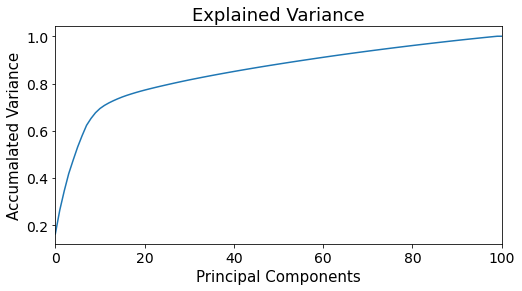

In [174]:
information_gain = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(information_gain)
# plt.plot([idx, idx], [information_gain[idx], information_gain[idx]], marker=".")
plt.xlim([0, 100])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Explained Variance", fontsize=18)
plt.ylabel("Accumalated Variance", fontsize=15)
plt.xlabel("Principal Components", fontsize=15)

Text(0.5, 0, 'Principal Components')

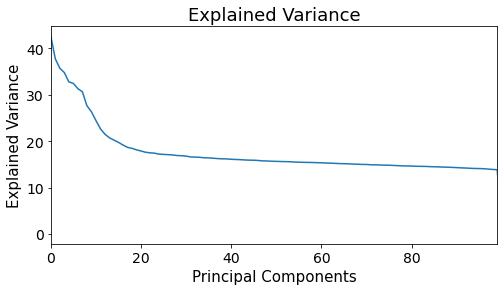

In [175]:

plt.figure(figsize=(8, 4))
plt.plot(np.sqrt(pca.singular_values_))
plt.xlim([0, 99])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Explained Variance", fontsize=18)
plt.ylabel("Explained Variance", fontsize=15)
plt.xlabel("Principal Components", fontsize=15)


Text(0.5, 0, 'Principal Components')

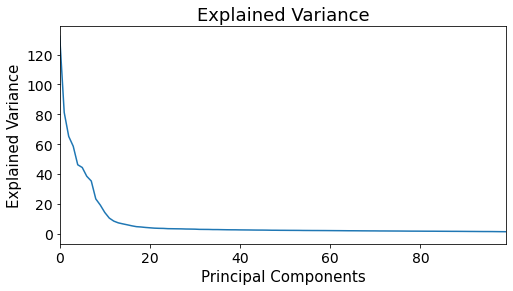

In [176]:
plt.figure(figsize=(8, 4))
plt.plot(pca.explained_variance_)
plt.xlim([0, 99])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Explained Variance", fontsize=18)
plt.ylabel("Explained Variance", fontsize=15)
plt.xlabel("Principal Components", fontsize=15)

In [311]:
@th.no_grad()
def explore_principle_direction(idx, U, model, zs, ratios=None):
    
    size = U.shape[1]
    n_samples = zs.shape[0]
    if ratios is None:
        ratios = np.linspace(-0.5, 0.5, 11)
   
    x = th.zeros((size,), device=model.device, dtype=zs.dtype)
    
    imgs = []
    for z in zs:
        for ratio in ratios:
            x[idx] = ratio
            z_ = z + th.matmul(U, x)
            
            img = th.squeeze(model(th.unsqueeze(z_, dim=0)))
            imgs.append(img)
    
    # make grid
    grid = torchvision.utils.make_grid(imgs, nrow=len(ratios), normalize=True)
    return grid


@th.no_grad()
def explore_principle_direction_pca(idx, E, mu, model, zs, ratios):
    
    size = U.shape[1]
    n_samples = zs.shape[0]
   
    
    imgs = []
    for z in zs:
        for ratio in ratios:
            l = model.l1(th.unsqueeze(z, dim=0))
            l = th.squeeze(l)
            l_pca = (l - mu).matmul(E.T)
            l_pca[idx] = 0 # ratio # 2*l_pca[idx]
            l_rec = l_pca.matmul(E) + mu
            l_rec = l_rec.view(1,  model.init_channels,
                    model.init_height,  model.init_width)
            
            img = th.squeeze(model.conv_blocks(l_rec))
            imgs.append(img)
        #print(2*l_pca[idx])
    # make grid
    grid = torchvision.utils.make_grid(imgs, nrow=len(ratios), normalize=True)
    return grid

In [250]:
zs = th.normal(0, 1, size=(15, model.generator.latent_dim), device=model.device) 
E = th.tensor(comp, device=model.device, dtype=zs.dtype)
mu = th.tensor(mean, device=model.device, dtype=zs.dtype)

([], [])

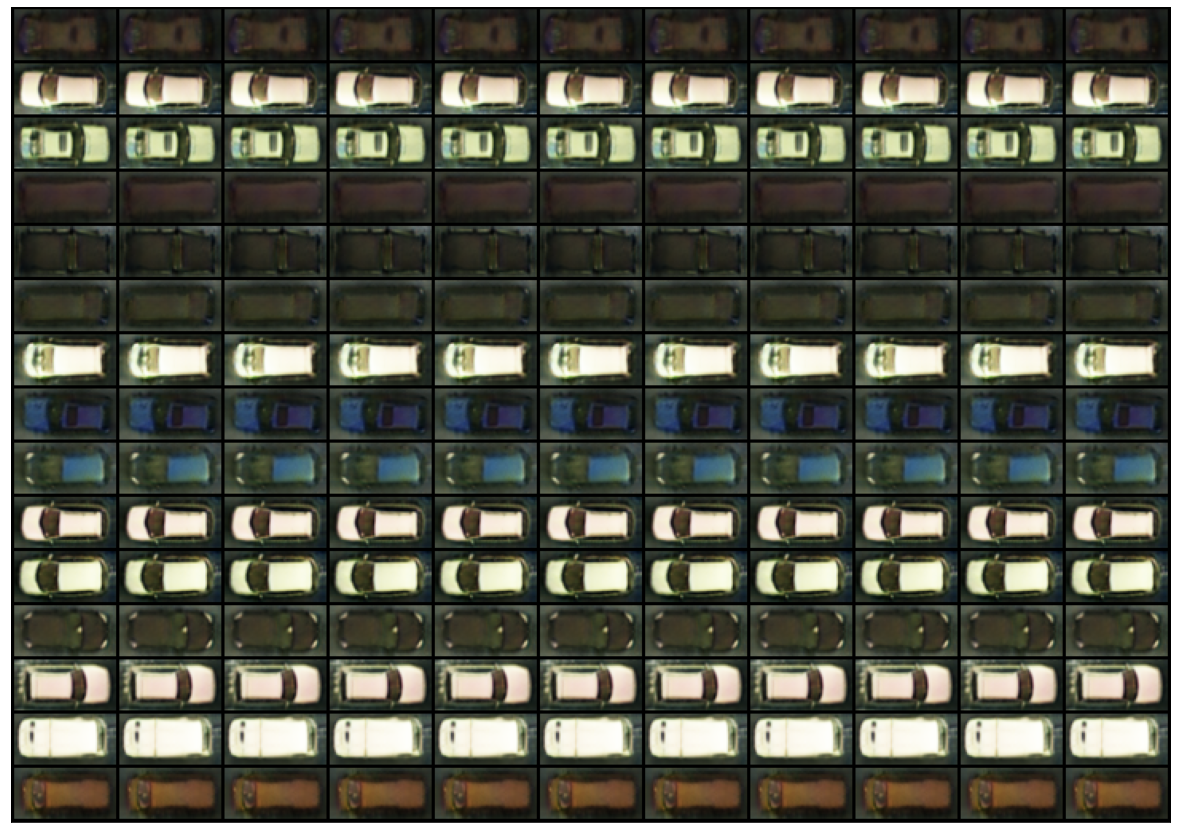

In [312]:
i = 4
scale = np.sqrt(pca.singular_values_)[i]
ratios = np.linspace(-scale, scale, 11)
grid = explore_principle_direction_pca(i, E, mu, model.generator, zs, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

([], [])

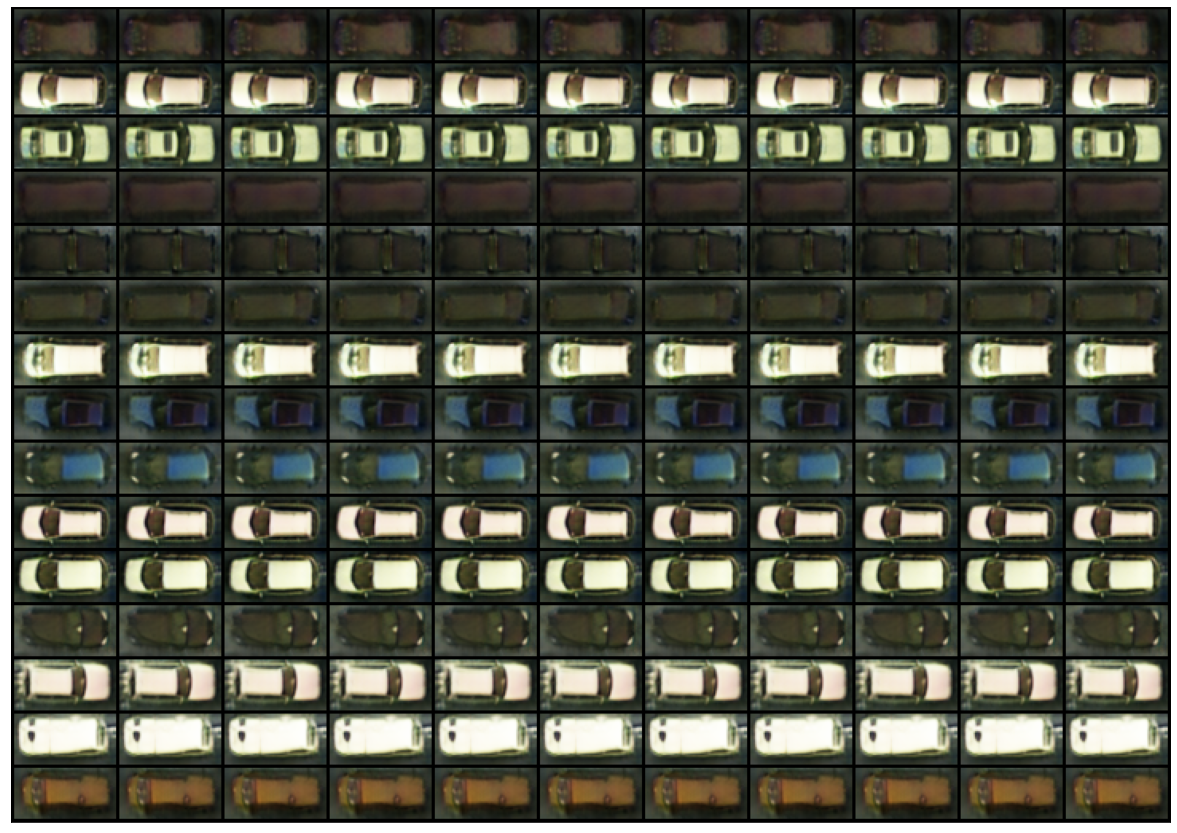

In [305]:
i = 4
scale = np.sqrt(pca.singular_values_)[i]
ratios = np.linspace(-scale, scale, 11)
grid = explore_principle_direction_pca(i, E, mu, model.generator, zs, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

In [233]:
zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
#zs = th.zeros((15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

In [283]:
i = 4
scale = np.sqrt(pca.singular_values_)[i]
ratios = np.linspace(-scale, scale, 11)
grid = explore_principle_direction(i, U, model, zs, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)

In [285]:
scale

32.7940743669207

([], [])

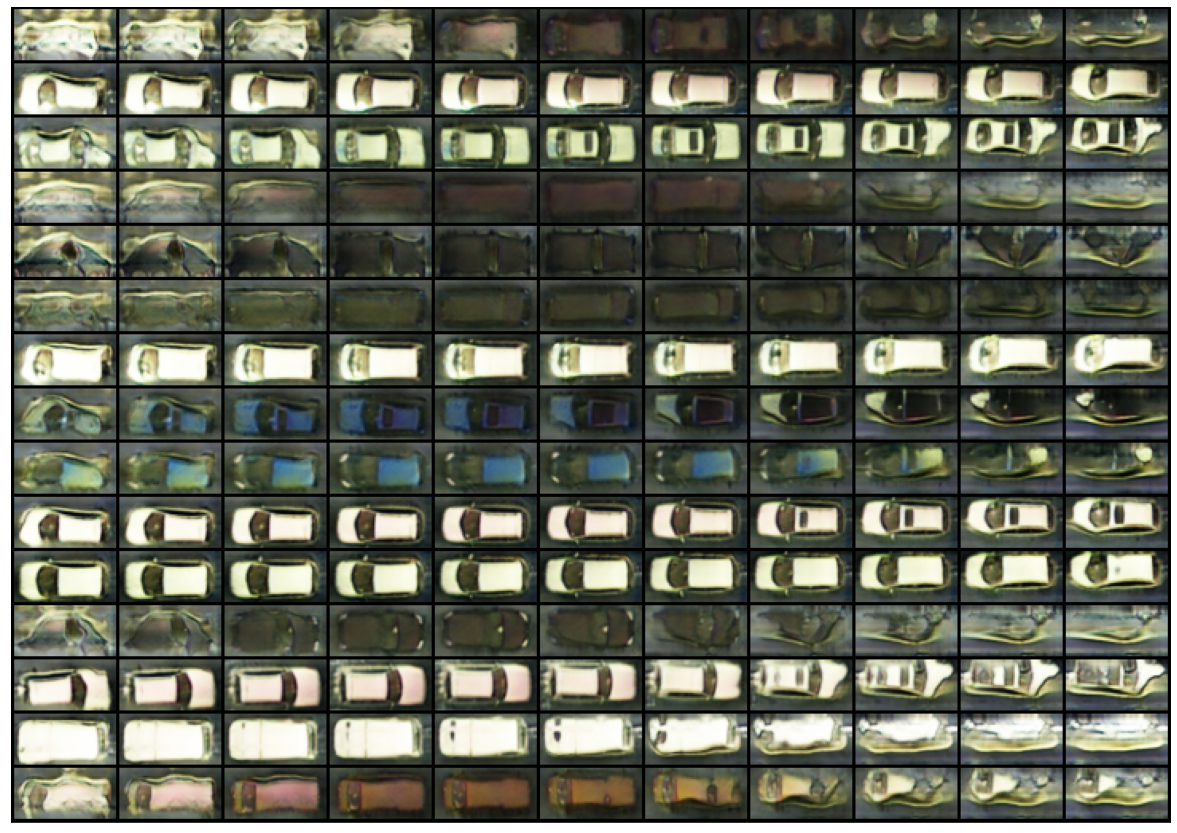

In [284]:
plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

In [ ]:
# input
model_checkpoint = "experiments/dcgan_resnet/lightning_logs/version_0/checkpoints/epoch=524.ckpt"
save_path = "experiments/ganspace/dcgan_resnet_version_0_epoch=524"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim 


dims_ = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 19, 20]
ratios_ = [[-50, 50], [-30, 30], 
          [-50, 50], [-50, 50], 
          [-50, 0], [0, 50], 
          [-50, 0], [-50, 50], 
          [0, 40], [-40 , 40], 
          [0, 50], [-50, 50], 
          [-70, 0], [-50, 50]]

np.save(os.path.join(save_path, layer, "important_dims.npy"), {"dims" : dims_, "ratios" : ratios_})

zs = th.zeros((1, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grids.append(explore_principle_direction(d, U, model, zs, ratios))
    
grid = torchvision.utils.make_grid(grids, nrow=1, normalize=True)
torchvision.utils.save_image(grid, os.path.join(save_path, layer, "pca_directions.png"))

zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grid = explore_principle_direction(d, U, model, zs, ratios)
    torchvision.utils.save_image(grid, os.path.join(save_path, layer, f"pca_dim={d}.png"))


In [4]:
# input
model_checkpoint = "experiments/big_image/lightning_logs/version_0/checkpoints/epoch=449.ckpt"
save_path = "experiments/ganspace/big_image_version_0_epoch=449"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim 0 : ratio [-50, 50] : make cars white and them left or right
# dim 1 : ratio [-30, 30] : makes cars white van or green
# dim 5 : ratio [-50, 50] : car becomes red or blue
# dim 6 : ratio [-50, 50] : makes car blue or redish with strips on top
# dim 7 : ratio [-50, 0] : adds bright spot in right side
# dim 8 : ratio [0, 50] : adds bright spot in left side
# dim 9 : ratio [-50, 0] : adds bright spot in left side
# dim 10 : ratio [-50, 50] : makes image brighter or darker
# dim 12 : ratio  [0, 40] : tries to add roof
# dim 11 : ratio [-40, 40] : makes bottom part brighter or top part darker
# dim 14 : ratio [0, 50] : makes car longer
# dim 15 : ratio [-50, 50] : adds car light bottom left or bends it to bottom right
# dim 19 : ratio [-70, 0] : bends it to bottom left
# dim 20 : ratio [-50, 50] : makes car smaller or rotates the car


dims_ = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 19, 20]
ratios_ = [[-50, 50], [-30, 30], 
          [-50, 50], [-50, 50], 
          [-50, 0], [0, 50], 
          [-50, 0], [-50, 50], 
          [0, 40], [-40 , 40], 
          [0, 50], [-50, 50], 
          [-70, 0], [-50, 50]]

np.save(os.path.join(save_path, layer, "important_dims.npy"), {"dims" : dims_, "ratios" : ratios_})

zs = th.zeros((1, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grids.append(explore_principle_direction(d, U, model, zs, ratios))
    
grid = torchvision.utils.make_grid(grids, nrow=1, normalize=True)
torchvision.utils.save_image(grid, os.path.join(save_path, layer, "pca_directions.png"))

zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grid = explore_principle_direction(d, U, model, zs, ratios)
    torchvision.utils.save_image(grid, os.path.join(save_path, layer, f"pca_dim={d}.png"))


NameError: name 'model' is not defined

In [5]:
# input
model_checkpoint = "experiments/dataaug/lightning_logs/version_1/checkpoints/epoch=774.ckpt"
save_path = "experiments/ganspace/dataaug_bn_default_epoch=774"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim 0 : ratio [-50, 50] : make cars white and them left or right
# dim 1 : ratio [-20, 20] : makes cars white van or green
# dim 3 : ratio [-20, 20] : moves car from top to bottom
# dim 5 : ratio [-40, 40] : car becomes red or gets strips on top
# dim 6 : ratio [-30, 0] : makes car blue
# dim 9 : ratio [-20, 20] : makes image brighter or darker
# dim 10 : ratio [-40, 0] : adds bright spot and makes car green
# dim 11 : ratio [-40, 40] : makes image darker and green or blue and bright spot on bottom
# dim 13 : ratio [-30, 30] : makes image red or green
# dim 14 : ratio [-60, 0] : adds car light front and back
# dim 16 : ratio [-60, 60] : lighting direction
# dim 17 : ratio [-50, 50] : changes the aspect ratio of car + lighting on front or back
# dim 20 : ratio [-40, 40] : twists the car and rotates little bit and adds light spot
# dim 25 : ratio [-70, 70] : makes car green or red and add bright spot on left or right
# dim 44 : ratio [-100, 0] : bending the car

dims_ = [0, 1, 3, 5, 6, 9, 10, 11, 13, 14, 16, 17, 20, 25, 44]
ratios = [[-50, 50], [-20, 20], 
          [-20, 20], [-40, 40], 
          [-30, 0], [-20, 20], 
          [-40, 0], [-40, 40], 
          [-30, 30], [-60 , 0], 
          [-60, 60], [-50, 50], 
          [-40, 40], [-70, 70], 
          [-100, 0]]

np.save(os.path.join(save_path, layer, "important_dims.npy"), {"dims" : dims_, "ratios" : ratios_})

zs = th.zeros((1, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grids.append(explore_principle_direction(d, U, model, zs, ratios))
    
grid = torchvision.utils.make_grid(grids, nrow=1, normalize=True)
torchvision.utils.save_image(grid, os.path.join(save_path, layer, "pca_directions.png"))

zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grid = explore_principle_direction(d, U, model, zs, ratios)
    torchvision.utils.save_image(grid, os.path.join(save_path, layer, f"pca_dim={d}.png"))


NameError: name 'model' is not defined